In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

os.chdir('..')

pd.set_option('mode.chained_assignment', None)

### 1. Cleaning the survey data

Read in the data with flood depth estimates and reclassify each of the survey responses with a numerical scale. We care most about the columns with location identifiers (shp_id) and flood level (flood_level). We are assuming that the reported flood level corresponds to the maximum flooding experienced by the survey respondent. 

Given that there are many responses for a given mauza, we will also need to get a summary measurement across all responses for a single mauza.

Our final dataframe should have one row for each mauza that has at least one survey response (so 643 rows total). 

In [2]:
# Read the csv and select columns of interest
df = pd.read_csv('data/CDP_Survey/household_locations_impactevaluation_matched_floodlevel.csv')
df_sel = df[['shp_id', 'flood_level']]

# How many unique mauzas do we have?
print("Unique mauzas: " + str(len(df_sel.shp_id.unique())))
# Compare this against the total number of responses
print("Total responses: " + str(len(df_sel.shp_id)))

# Create a dict to map flood level to a numerical scale
flood_levels = df_sel.flood_level.unique()
flood_score = {
    flood_levels[0]: 1,
    flood_levels[1]: 2, 
    flood_levels[2]: 3,
    flood_levels[3]: 4,
    flood_levels[4]: 5
}
df_sel['flood_score'] = df['flood_level'].map(flood_score)

# Group by and get the median, mean, standard deviation, and number of responses
df_avg_flood = df_sel.groupby('shp_id').aggregate([np.mean, np.median, np.std, 'count']).reset_index()
df_avg_flood.columns = df_avg_flood.columns.droplevel(0)
df_avg_flood.columns = ['OBJECTID', 'mean', 'median', 'std', 'count']

Unique mauzas: 643
Total responses: 9130


### 2. Creating a flood depth map

To map the flood depth, we need to join this cleaned data with the mauza shapefile that we have. We'll then create a simple choropleth map of both the mean and the median flooding levels. 

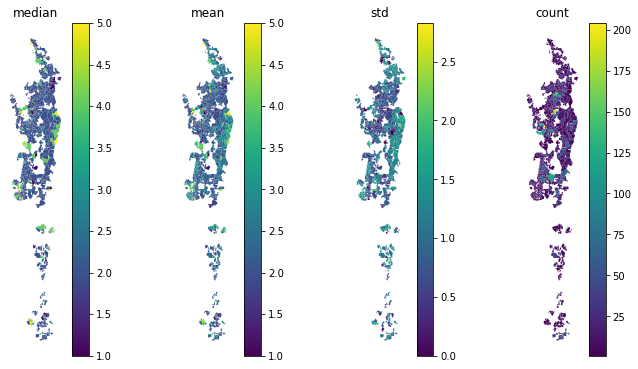

In [3]:
# Read in shp and join with the data
df_shp = gpd.read_file('data/ADM_Shp/selected_distict_mauza.shp')
df_flood_shp = df_shp.merge(df_avg_flood, on='OBJECTID', how='right')

# Set up the figures and items to iterate through
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10, 10))
axes_list = [item for sublist in axes for item in sublist] 
map_list = ['median', 'mean', 'std', 'count']

# Loop through to make the plots
for measure in map_list:
    ax = axes_list.pop(0)
    df_flood_shp.plot(column=measure, label=measure, ax=ax, legend=True)
    ax.set_title(measure)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axis_off()

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
    
plt.tight_layout()
plt.savefig(os.path.join('results/figures/cdp-survey', 'CDP_Survey_Flood_Depth.png'), dpi=300)

### 3. Join with the Sentinel-1 flood fraction estimates

We want to compare the reported flood depth from the survey against the maximum flooding estimates derived from Sentinel-1 data. 

TO DO: 
- Generate comparison map of the max Gaussian fit estimates for mauzas with survey responses - visually compare the two spatial distributions
- Explore methods to quantitatively compare two spatial distributions - to what extent do mauzas with overall high reported flood depth correspond with mauzas that have high mximum flooding fractions? 